# Explore Netflix Data with a Neo4j graph


The object of this notebook is 
* to test the interaction with Neo4j 
* and use the graph algorithms to find **similarities and recommendations**

Here is the model of graph I have defined :
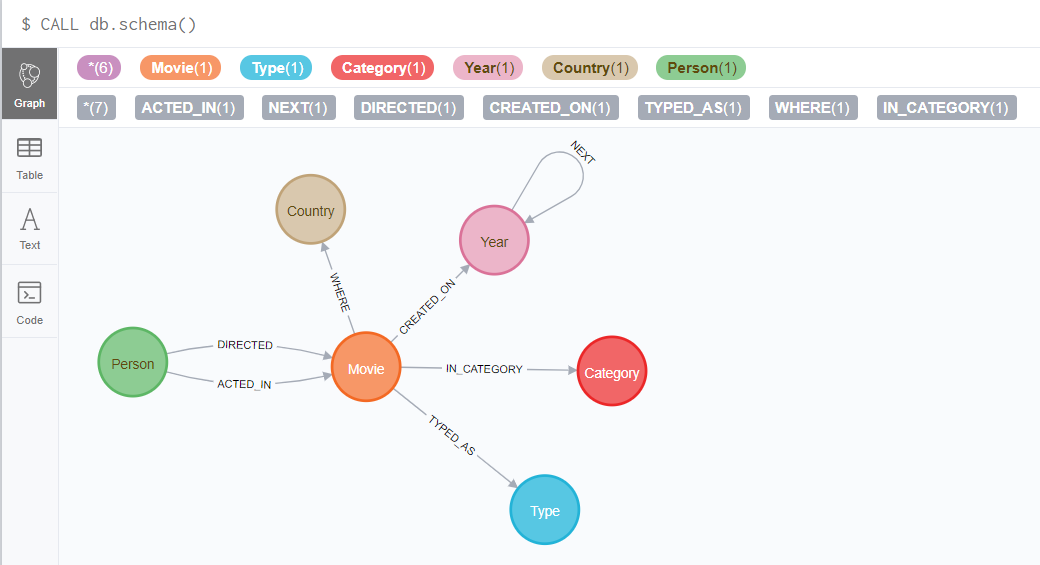


# Configuration
To interact with Neo4J, you need a Sandbox Neo4j.
A online sandbox can be launched for 3 days here https://neo4j.com/sandbox-v3 , you just have to sign in.

Once your sandbox is launched, information for the connexion are available :

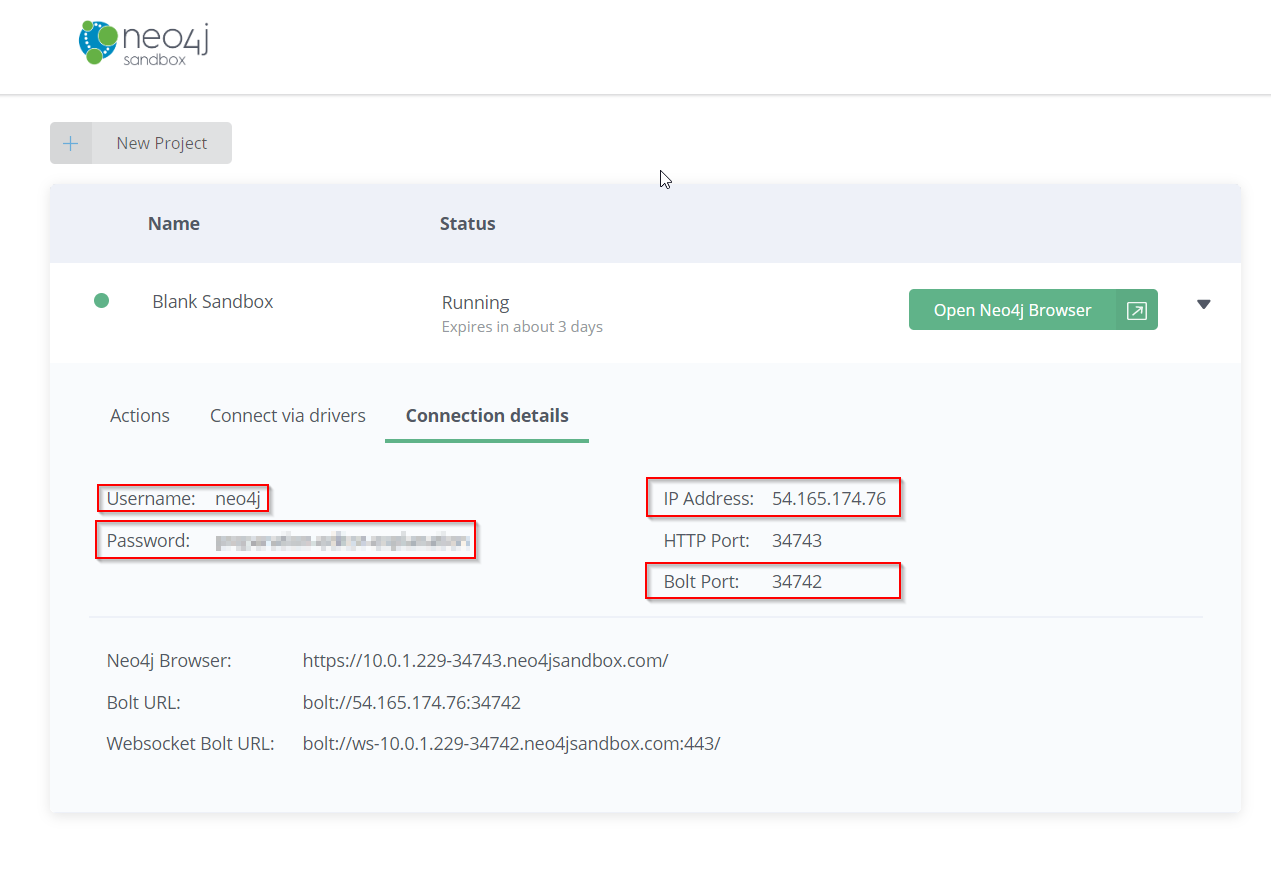

In [ ]:
# The librairie py2neo is used as driver to connect python to a Neo4j database
!pip install py2neo

In [ ]:
# import librairies
import numpy as np 
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time

### Load the netflix data

In [ ]:
# load the data
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

df.head()

### Connexion to the neo4j online sandbox 

In [ ]:
#Connect to neo4j sandbox
ip="54.165.174.76"
port="34742"
pwd="preparation-editor-explanation"
graph = Graph("bolt://"+ip+":"+port, auth=("neo4j", pwd))

# Load the data from the dataframe to neo4j graph DB

> Remark : execution time can be long, about 6 minutes for requests as "create movies" or "create persons"

> So execute it, only once  **put LOAD_DATA = false, to not load data again**


I have tried the idea to not send a lot of queries through the net :
* the first request load all the data as properties of the nodes Movies.
* the other requests build the other nodes with these properties
* at the end, the final request delete the unused properties



In [ ]:
LOAD_DATA = False

def run_request(request,LOAD_DATA=False):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [ ]:
# DELETE ALL NODES AND RELATIONSHIPS
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

In [ ]:
# CREATE MOVIES

request ="""
CREATE (m:Movie {id: {show_id},title:{title}})
SET 
m.director = {director},
m.country = {country},
m.date_str = {date_added}, 
m.release_year = {release_year},
m.rating = {rating},
m.duration = {duration} ,
m.listed_in = {listed_in} ,
m.description = {description},
m.cast={cast},
m.year = {year},
m.month = {month},
m.day = {day},
m.type = {type_movie}
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  show_id=row['show_id'],
                  title=row['title'],
                  director=None if pd.isnull(row['director']) else row['director'],
                  country=None if pd.isnull(row['country']) else row['country'],
                  date_added= None if pd.isnull(row['date_added']) else row['date_added'].strftime('%Y-%m-%d'),
                  release_year=None if pd.isnull(row['release_year']) else row['release_year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],          
                  duration=None if pd.isnull(row['duration']) else row['duration'],
                  listed_in=None if pd.isnull(row['listed_in']) else row['listed_in'],
                  description=None if pd.isnull(row['description']) else row['description'],
                  cast= None if pd.isnull(row['cast']) else row['cast'],
                  year=None if pd.isnull(row['year']) else row['year'],
                  month=None if pd.isnull(row['month']) else row['month'],
                  day=None if pd.isnull(row['day']) else row['day'],
                  type_movie=None if pd.isnull(row['type']) else row['type']
                  )
        if (index%500==0):
            exec_time = time.time() - start_time
            print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')
        
    exec_time = time.time() - start_time
    print(f' ... End ... -- {exec_time} seconds --')        

In [ ]:
# CREATE  PERSONS
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ',') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)   

In [ ]:
# CREATE CATEGORIES    
request ="""    
MATCH (m:Movie)
WHERE m.listed_in IS NOT NULL
WITH m
UNWIND split(m.listed_in, ',') AS category
MERGE (c:Category {name: trim(category)})
MERGE (m)-[r:IN_CATEGORY]->(c);
"""    
run_request(request,LOAD_DATA)

In [ ]:
# CREATE TYPE
request =""" 
MATCH (m:Movie)
WHERE m.type IS NOT NULL
WITH m
MERGE (t:Type {type: m.type})
MERGE (m)-[r:TYPED_AS]->(t);
"""
run_request(request,LOAD_DATA) 

In [ ]:
# CREATE DIRECTOR
request =""" 
MATCH (m:Movie)
WHERE m.director IS NOT NULL
WITH m
MERGE (d:Person {name: m.director})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request,LOAD_DATA) 

In [ ]:
# CREATE COUNTRIES
request =""" 
MATCH (m:Movie)
WHERE m.country IS NOT NULL
MERGE (c:Country {name: trim(m.country)})
MERGE (m)-[:WHERE]->(c);
"""
run_request(request,LOAD_DATA) 

In [ ]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request,LOAD_DATA) 

In [ ]:
# BUILD THE WORK_WITH RELATIONSHIP
#request = """
#MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
#MERGE (p)-[r:WORK_WITH]-(p2);
#"""
#run_request(request,LOAD_DATA) 

In [ ]:
# Create Time Tree Index
request="""
CREATE INDEX ON :Year(value);
"""
run_request(request,LOAD_DATA)

In [ ]:
# Create Years
request="""
WITH range(2012, 2019) AS years, range(1,12) AS months
FOREACH(year IN years |
  CREATE (y:Year {value: year}));
"""
run_request(request,LOAD_DATA)

In [ ]:
# Connect Years Sequentially
request="""
MATCH (year:Year)
WITH year
ORDER BY year.value
WITH collect(year) AS years
FOREACH(i in RANGE(0, size(years)-2) |
    FOREACH(year1 in [years[i]] |
        FOREACH(year2 in [years[i+1]] |
            MERGE (year1)-[:NEXT]->(year2))));
"""
run_request(request,LOAD_DATA)

In [ ]:
request="""
MATCH (m:Movie)
WITH m, m.year AS y
MATCH (year:Year {value: y})
MERGE (m)-[:CREATED_ON]->(year)
RETURN m,year;
"""
run_request(request,LOAD_DATA)

# Graph cardinalities

In [ ]:
# Nodes Cardinalities
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities",figsize=(10,8))
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.plot(kind='bar', x=nodes_df['label'], y=nodes_df['count'], legend=None, title="Node Cardinalities")
plt.show()

In [ ]:
# Relations Ship Cardinalities
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TOP 5 ACTOR - Greatest Number of films played 

In [ ]:

request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.title) as movies,count(*) as total
RETURN  p.name, movies,total
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

# Count by Category
> The grand total does not equal the number of movies, because a movie can be in several categories

In [ ]:
request="""
MATCH (c:Category)<-[rel:IN_CATEGORY]-(m:Movie)
WITH c.name as category,count(*) as total
RETURN  category,total
ORDER BY total DESC
"""
result = graph.run(request).to_data_frame()
result.plot.barh(x='category', y='total',figsize=(10,8))
plt.show()

# Shortest between 2 persons
> If I want to meet someone, who should I ask to be present?


In [ ]:

def who_be_present(I_AM,I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
    MATCH (cs:Person { name: {pfrom} }),(ms:Person { name: {pto} }), p = shortestPath((cs)-[:ACTED_IN|:DIRECTED*]-(ms))
    WHERE length(p)> 1 
    RETURN p
    """
    cursor = graph.run(request,pfrom=I_AM,pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')
        
        
I_AM='Brad Anderson'
I_WANT_TO_MEET='Brad Pitt'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Kanwaljeet Singh'
I_WANT_TO_MEET='Nick Nolte'
who_be_present(I_AM,I_WANT_TO_MEET)


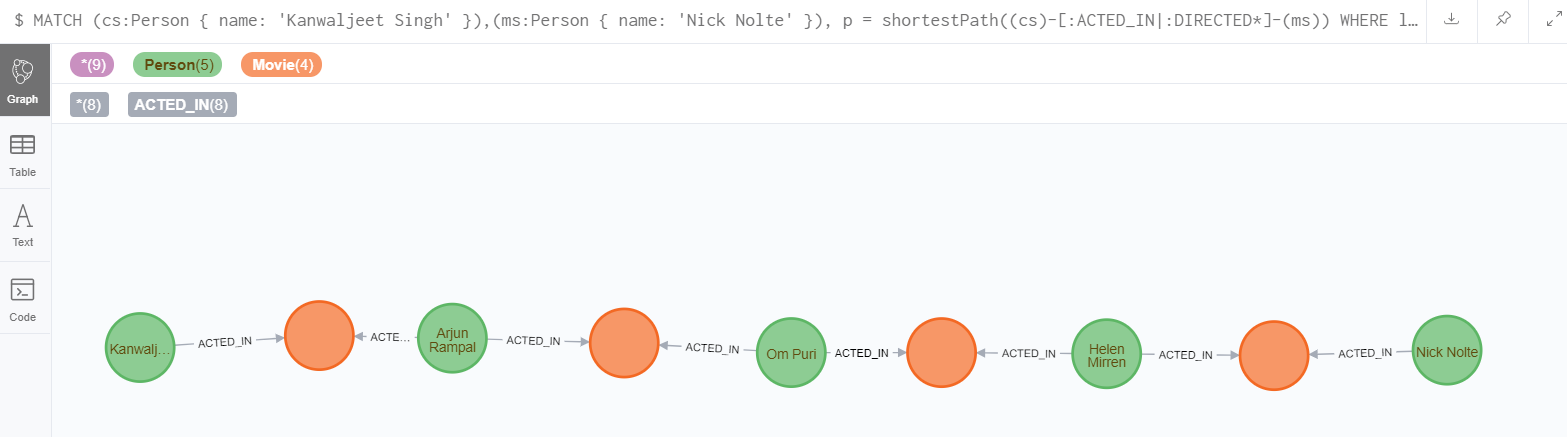

# Similarity between categories

The similarity between two categories is evaluated with the overlap of the movies sets that each category contains :
> Overlap similarity measures overlap between two sets. It is defined as the size of the intersection of two sets, divided by the size of the smaller of the two sets.
https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/overlap/


$$ O(A,B) = \frac{|A \cap B|}{min(|A|,|B|)}$$


Based on this similarity, we can plot a dendogram

In [ ]:
# SIMILARITY BETWEEN CATEGORY
query = """
MATCH (m:Movie)-[:IN_CATEGORY]->(cat:Category)
WITH {item:id(cat), categories: collect(id(m))} as userData
WITH collect(userData) as data
CALL algo.similarity.overlap.stream(data)
YIELD item1, item2, count1, count2, intersection, similarity
RETURN algo.asNode(item1).name AS from, algo.asNode(item2).name AS to,
       count1, count2, intersection, similarity
ORDER BY from,to DESC
"""
start_time = time.time()
cat_result = graph.run(query).to_data_frame()
exec_time = time.time() - start_time
print(f'-- {exec_time} seconds --')
cat_result.head()

In [ ]:
# Create the set of categories
set1 = set(cat_result['to'].unique())
set2 = set(cat_result['from'].unique())
categories = np.asarray(list(set1 | set2))
categories.sort()
nbr_cat = categories.shape[0]

# Create a dictionary key=categorie , value = index 
cat_index = np.arange(nbr_cat)
dictionary = dict(zip(categories, cat_index))

# Create a matrix of distance ( distance = 1 - similarity )
matrix = 1 - np.eye(nbr_cat)
for index, row in cat_result.iterrows():
    matrix[dictionary[row['from']],dictionary[row['to']]]=1-row['similarity']
    matrix[dictionary[row['to']],dictionary[row['from']]]=1-row['similarity']

# Convert the matrix to a 1d condensed matrix
cmatrix = []
for i in range(0,nbr_cat-1):
    for j in range(i+1,nbr_cat):
        cmatrix.append(matrix[i,j])

In [ ]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
linkage = linkage(np.asarray(cmatrix))

fig, axes = plt.subplots(1, 1, figsize=(12, 12))
dendro  = dendrogram(linkage,labels=categories,orientation='right',ax=axes,color_threshold=0.5)
plt.show()

# Recommendation

> These algorithms help determine the closeness of a pair of nodes. 

> Adamic Adar is a measure used to compute the closeness of nodes based on their shared neighbors.

https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/adamic-adar/

x and y are nodes (Movies)
* if N(x) is the set of nodes adjacent to x
* if N(y) is the set of nodes adjacent to y

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$


In [ ]:
# LINK PREDICTION BETWEEN MOVIES
request_link_prediction_movie="""
MATCH (a:Movie {title:{ptitle}} )-[*2]-(b:Movie)
WHERE a <> b AND a.title < b.title
WITH DISTINCT a,b
RETURN a.title as title, b.title as recommendation, algo.linkprediction.adamicAdar(a, b) AS score
ORDER BY score DESC
LIMIT 10
"""
print(graph.run(request_link_prediction_movie,ptitle='Stranger Things').to_data_frame())
print(graph.run(request_link_prediction_movie,ptitle="Ocean's Thirteen").to_data_frame())


# Evolution over year - Number of movies by countries

In [ ]:
request="""
MATCH (y:Year {value: 2012})-[:NEXT*0..10]->(y2:Year)<-[:CREATED_ON]-(f:Movie)-[r:WHERE]->(c:Country)
RETURN y2.value as year,c.name as country,count(r) as count
ORDER BY year DESC, count DESC
"""
result = graph.run(request).to_data_frame()
filter=result['country'][:10]

In [ ]:
temp= result.loc[result['country'].isin(filter)]
temp=temp.set_index(['year', 'country'])
temp=temp.unstack(level=-1)
temp.fillna(0,inplace=True)
temp.plot(figsize=(12, 12)).legend(bbox_to_anchor=(1, 1))
plt.show()